# Notebook for SDS final project


In [1]:
import json
from collections import Counter
import numpy as np
import operator
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import networkx as nx
import base64
from collections import defaultdict
import sys,os
import math
import random
import operator
import csv
import matplotlib.pylab as pyl
import itertools
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy.integrate import quad
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import random
from mlxtend.frequent_patterns import fpgrowth

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in the json files
def load_json_data(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

events_england = load_json_data('./data/events/events_England.json')
players_england = load_json_data('./data/players.json')

free_kick_events = [event for event in events_england if event['subEventId'] == 32 or event['subEventId'] == 31]
free_kick_instance = free_kick_events[0]

In [3]:
# function to seperate the freekicks into zones
def get_zone(x, y):
    if x < 50:
        return 'Own half'
    elif x >= 50 and y < 34:
        return 'Opponent half left'
    elif x >= 50 and 34 < y < 67:
        return 'Opponent half center'
    elif x >= 50 and y >= 67:
        return 'Opponent half right'

In [4]:
SUCCESS_TAGS = {101, 201}  # goal, opportunity
SETPIECE_TAGS = {31, 32, 33, 34, 35, 36}
match_ids = set(event['matchId'] for event in events_england)

# loop to find succesful free kick sequences
# loop over all matches, then all freekicks in match to find succesful freekicks
successful_sequences = {}
for match_id in match_ids:
    match_events = [event for event in events_england if event['matchId'] == match_id]
    all_events_sorted = sorted(match_events, key=lambda x: x['eventSec'])
    free_kick_events = [event for event in all_events_sorted if event['subEventId'] == 32 or event['subEventId'] == 31]

    for free_kick_event in free_kick_events:
        free_kick_time = free_kick_event['eventSec']
        subsequent_events = [event for event in all_events_sorted if free_kick_time <= event['eventSec'] <= free_kick_time + 15]

        fk_team = free_kick_event['teamId']
        sequence = []
        is_successful_for_fk_team = False

        for event in subsequent_events:
            if event['teamId'] != fk_team:
                if 'positions' not in event: # or len(event['positions']) < 2:
                    break
                # normalizing positions
                original_positions = event['positions']
                positions_copy = [{'x': 100 - pos['x'], 'y': 100 - pos['y']} for pos in original_positions]
                event['positions'] = positions_copy

            sequence.append(event)

            if event['subEventId'] not in SETPIECE_TAGS:
                if any(tag['id'] in SUCCESS_TAGS for tag in event['tags']):
                    if event['teamId'] == fk_team:
                        is_successful_for_fk_team = True
                    break # break after event with success tag

        if is_successful_for_fk_team:
            successful_sequences[free_kick_event['id']] = sequence

print(f"{len(successful_sequences)} successful set piece sequences.")


681 successful set piece sequences.


In [5]:

# dinding subsets for the zones in our analysis
def segment_sequences_by_zone(successful_sequences, target_zone='Opponent half right'):
    segmented = {}
    for id, sequence in successful_sequences.items():
        fk = sequence[0]
        
        if 'positions' not in fk or not fk['positions']:
            continue
        
        start_x = fk['positions'][0]['x']
        start_y = fk['positions'][0]['y']
        zone = get_zone(start_x, start_y)
        
        if zone != target_zone:
            continue
        segmented[id] = sequence
        
    return segmented

segmented = segment_sequences_by_zone(successful_sequences, target_zone='Opponent half right')

print(f"# sequences in target zone: {len(segmented)}")


# sequences in target zone: 191


In [6]:
# analysis zones
def get_analysis_zone(x, y):
    # gk box
    if 80 > y > 20:
        if x < 18:
            return 'Own goalkeeper box'
        elif x > 82:
            return 'Opponent goalkeeper box'
    
    # wing
    if y < 20:
            return 'right wing'
    elif y > 80:
            return 'left wing'
        
    
    # midfield
    if y < 80 and y > 20:
        if 18 < x < 39:
            return 'defensive midfield'
        elif 39 < x < 60:
            return 'center midfield'
        elif 60 < x < 82:
            return 'attacking midfield'
    
    return 'other'

def event_to_features(event):
    zone = get_analysis_zone(event['positions'][0]['x'], event['positions'][0]['y'])
    return {
        'eventId': event['eventId'],
        'subEventId': event['subEventId'],
        'zone': zone,
        'tags': [tag['id'] for tag in event['tags']]
    }

def sequence_to_feature_vectors(sequence):
    return [event_to_features(event) for event in sequence]

sequences_feature_vectors = {k: sequence_to_feature_vectors(v) for k, v in segmented.items()}


In [7]:
#mapping of zone names to numerical values
unique_zones = set()
for seq in sequences_feature_vectors.values():
    for event in seq:
        unique_zones.add(event['zone'])

zone_to_num = {zone: idx for idx, zone in enumerate(unique_zones)}

def sequence_to_dtw_zone_features(sequence):
    return np.array([zone_to_num[event['zone']] for event in sequence])

dtw_sequences_zones = {k: sequence_to_dtw_zone_features(v) for k, v in sequences_feature_vectors.items()}


In [8]:
from dtw import *

dtw_distances_zones = {}
sequence_ids = list(dtw_sequences_zones.keys())
for i in range(len(sequence_ids)):
    for j in range(i+1, len(sequence_ids)):
        s1, s2 = dtw_sequences_zones[sequence_ids[i]], dtw_sequences_zones[sequence_ids[j]]
        distance = dtw(s1.reshape(-1, 1), s2.reshape(-1, 1), keep_internals=True).distance
        dtw_distances_zones[(sequence_ids[i], sequence_ids[j])] = distance


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [9]:
from sklearn.cluster import KMeans
import numpy as np

# distance matrix
distance_matrix_zones = np.zeros((len(sequence_ids), len(sequence_ids)))
for (i, j), distance in dtw_distances_zones.items():
    idx_i, idx_j = sequence_ids.index(i), sequence_ids.index(j)
    distance_matrix_zones[idx_i, idx_j] = distance
    distance_matrix_zones[idx_j, idx_i] = distance

num_clusters = 7
kmeans_zones = KMeans(n_clusters=num_clusters)
clusters_zones = kmeans_zones.fit_predict(distance_matrix_zones)

clustered_sequences_zones = defaultdict(list)
for idx, cluster in enumerate(clusters_zones):
    clustered_sequences_zones[cluster].append(sequence_ids[idx])


In [10]:
def calculate_percentage(sequences, threshold=40):
    count = 0
    for sequence in sequences:
        # print(sequence[1])
        # if len(sequence) > 1 and sequence[1]['positions'][0]['y'] < threshold:
        if sequence[0]['subEventId'] == 32:
            
            count += 1
    return (count / len(sequences)) * 100 if sequences else 0


In [ ]:
percentage = calculate_percentage(sequences_to_plot, threshold=50)
print(f"{percentage:.2f}%")


In [26]:
len(clustered_sequences_zones[5])

15

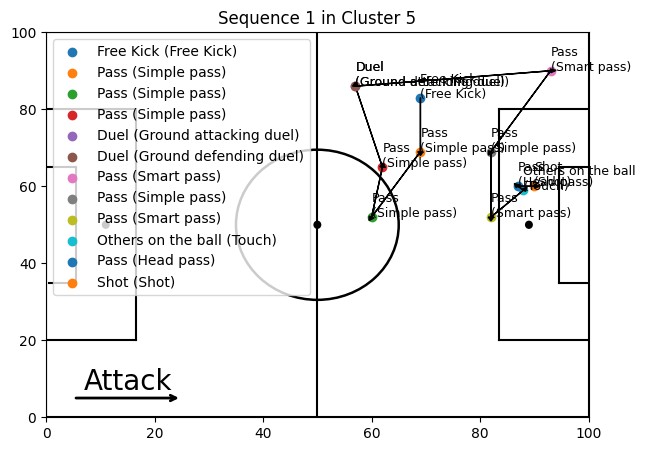

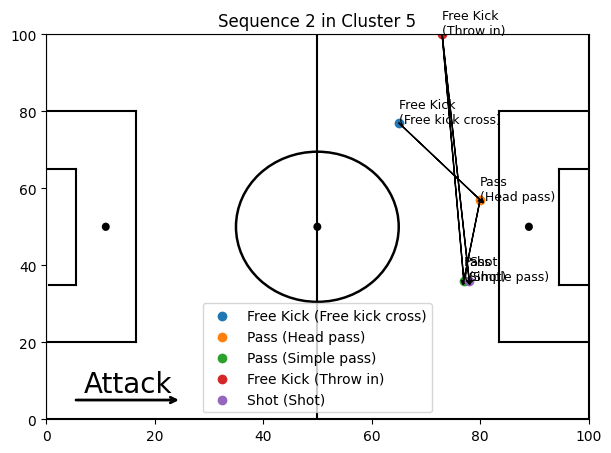

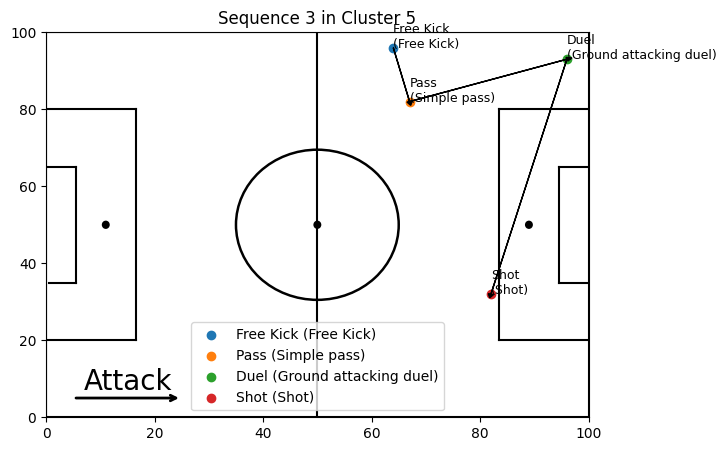

In [28]:
def plot_sequence(sequence, title):
    fig, ax = pitch() # run pitch function at the end of the notebook first
    
    prev_x, prev_y = None, None
    for idx, event in enumerate(sequence):
        x = event['positions'][0]['x']
        y = event['positions'][0]['y']
        event_label = eventid2name.get(event['eventId'], f"Unknown Event {event['eventId']}")
        subevent_label = subeventid2name.get(event['subEventId'], f"Unknown SubEvent {event['subEventId']}")
        
        label = f"{event_label} ({subevent_label})"
        
        ax.scatter(x, y, label=label)
        ax.text(x, y, f"{event_label}\n({subevent_label})", fontsize=9)
        
        if prev_x is not None and prev_y is not None:
            ax.arrow(prev_x, prev_y, x - prev_x, y - prev_y, head_width=1, head_length=1, fc='k', ec='k')
        
        prev_x, prev_y = x, y
    
    plt.title(title)
    plt.legend()
    plt.show()

# change this for different clusters
cluster_to_plot = 5 
sequences_to_plot = []

if cluster_to_plot in clustered_sequences_zones:
    seq_ids = clustered_sequences_zones[cluster_to_plot][:3]  # change for more plots
    for seq_id in seq_ids:
        sequence = successful_sequences[seq_id]
        
        formatted_sequence = []
        for event in sequence:
            formatted_sequence.append({
                'positions': [{'x': event['positions'][0]['x'], 'y': event['positions'][0]['y']}],
                'eventId': event['eventId'],
                'subEventId': event['subEventId']
            })
        
        sequences_to_plot.append(formatted_sequence)

for i, sequence in enumerate(sequences_to_plot):
    plot_sequence(sequence, title=f"Sequence {i+1} in Cluster {cluster_to_plot}")


In [21]:
# mapping for plots
eventid2name = {
    1: 'Duel',
    2: 'Foul',
    3: 'Free Kick',
    4: 'Goalkeeper leaving line',
    5: 'Interruption',
    6: 'Offside',
    7: 'Others on the ball',
    8: 'Pass',
    9: 'Save attempt',
    10: 'Shot'
}

subeventid2name = {
    10: 'Air duel',
    11: 'Ground attacking duel',
    12: 'Ground defending duel',
    13: 'Ground loose ball duel',
    20: 'Foul',
    21: 'Hand foul',
    22: 'Late card foul',
    23: 'Out of game foul',
    24: 'Protest',
    25: 'Simulation',
    26: 'Time lost foul',
    27: 'Violent Foul',
    30: 'Corner',
    31: 'Free Kick',
    32: 'Free kick cross',
    33: 'Free kick shot',
    34: 'Goal kick',
    35: 'Penalty',
    36: 'Throw in',
    40: 'Goalkeeper leaving line',
    50: 'Ball out of the field',
    51: 'Whistle',
    60: 'Offside',
    70: 'Acceleration',
    71: 'Clearance',
    72: 'Touch',
    80: 'Cross',
    81: 'Hand pass',
    82: 'Head pass',
    83: 'High pass',
    84: 'Launch',
    85: 'Simple pass',
    86: 'Smart pass',
    90: 'Reflexes',
    91: 'Save attempt',
    100: 'Shot'
}

tagsname = {
    101: 'Goal',
    102: 'own_goal',
    301: 'assist',
    302: 'keyPass',
    1901: 'counter_attack',
    401: 'Left',
    402: 'Right',
    403: 'head/body',
    1101: 'direct',
    1102: 'indirect',
    2001: 'dangerous_ball_lost',
    2101: 'blocked',
    801: 'high',
    802: 'low',
    1401: 'interception',
    1501: 'clearance',
    201: 'opportunity',
    1301: 'Feint',
    1302: 'missed ball',
    501: 'free_space_r',
    502: 'free_space_l',
    503: 'take_on_l',
    504: 'take_on_r',
    1601: 'sliding_tackle',
    601: 'anticipated',
    602: 'anticipation',
    1701: 'red_card',
    1702: 'yellow_card',
    1703: 'second_yellow_card',
    1201: 'gb',
    1202: 'gbr',
    1203: 'gc',
    1204: 'gl',
    1205: 'glb',
    1206: 'gr',
    1207: 'gt',
    1208: 'gtl',
    1209: 'gtr',
    1210: 'obr',
    1211: 'ol',
    1212: 'olb',
    1213: 'or',
    1214: 'ot',
    1215: 'otl',
    1216: 'otr',
    1217: 'pbr',
    1218: 'pl',
    1219: 'plb',
    1220: 'pr',
    1221: 'pt',
    1222: 'ptl',
    1223: 'ptr',
    901: 'through',
    1001: 'fairplay',
    701: 'lost',
    702: 'neutral',
    703: 'won',
    1801: 'accurate',
    1802: 'not accurate'
}


# plotting functions from notebook by original authors

In [13]:
def pitch():
    """
    code to plot a soccer pitch 
    """
    #create figure
    fig,ax=plt.subplots(figsize=(7,5))
    
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,100], color="black")
    plt.plot([0,100],[100,100], color="black")
    plt.plot([100,100],[100,0], color="black")
    plt.plot([100,0],[0,0], color="black")
    plt.plot([50,50],[0,100], color="black")

    #Left Penalty Area
    plt.plot([16.5,16.5],[80,20],color="black")
    plt.plot([0,16.5],[80,80],color="black")
    plt.plot([16.5,0],[20,20],color="black")

    #Right Penalty Area
    plt.plot([83.5,100],[80,80],color="black")
    plt.plot([83.5,83.5],[80,20],color="black")
    plt.plot([83.5,100],[20,20],color="black")

    #Left 6-yard Box
    plt.plot([0,5.5],[65,65],color="black")
    plt.plot([5.5,5.5],[65,35],color="black")
    plt.plot([5.5,0.5],[35,35],color="black")

    #Right 6-yard Box
    plt.plot([100,94.5],[65,65],color="black")
    plt.plot([94.5,94.5],[65,35],color="black")
    plt.plot([94.5,100],[35,35],color="black")

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor="black", facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor="black", facecolor="black", lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    plt.xlim(0,100)
    plt.ylim(0,100)
    
    ax.annotate("", xy=(25, 5), xytext=(5, 5),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.text(7,7,'Attack',fontsize=20)
    return fig,ax

In [14]:
def draw_pitch(pitch, line, orientation, view):
    """
    Draw a soccer pitch given the pitch, the orientation, the view and the line
    
    Parameters
    ----------
    pitch
    
    """
    orientation = orientation
    view = view
    line = line
    pitch = pitch
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(93,34,color=line,zorder=5)
        plt.scatter(11,34,color=line,zorder=5)
        plt.scatter(52,34,color=line,zorder=5)

        circle1 = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)

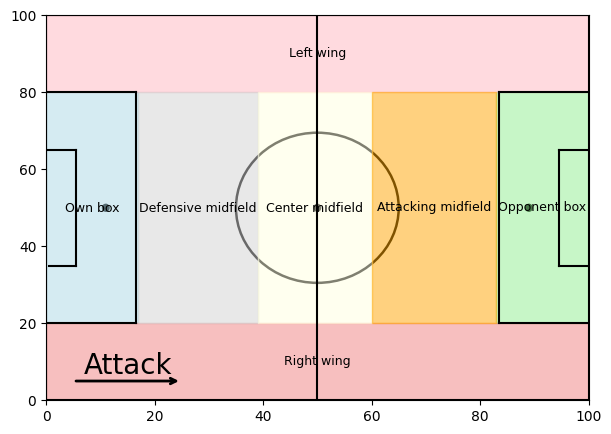

In [19]:

def plot_zones():
    fig, ax = pitch()
    
    zones = {
        'Own box': {'x_range': (0, 17), 'y_range': (20, 80)},
        'Opponent box': {'x_range': (83, 100), 'y_range': (20, 80)},
        'Left wing': {'x_range': (0, 100), 'y_range': (80, 100)},
        'Right wing': {'x_range': (0, 100), 'y_range': (0, 20)},
        'Defensive midfield': {'x_range': (17, 39), 'y_range': (20, 80)},
        'Center midfield': {'x_range': (39, 60), 'y_range': (20, 80)},
        'Attacking midfield': {'x_range': (60, 83), 'y_range': (20, 80)}
    }

    colors = {
        'Own box': 'lightblue',
        'Opponent box': 'lightgreen',
        'Left wing': 'lightpink',
        'Right wing': 'lightcoral',
        'Defensive midfield': 'lightgray',
        'Center midfield': 'lightyellow',
        'Attacking midfield': 'orange'
    }

    for zone, bounds in zones.items():
        x_start, x_end = bounds['x_range']
        y_start, y_end = bounds['y_range']
        ax.fill_betweenx([y_start, y_end], x_start, x_end, color=colors[zone], alpha=0.5)
        ax.text((x_start + x_end) / 2, (y_start + y_end) / 2, zone, ha='center', va='center', fontsize=9, color='black')

    plt.show()

plot_zones()
